In [3]:
import os
os.environ["JAVA_HOME"] = "C:/Java/jdk1.8.0_261"
os.environ["SPARK_HOME"] = "D:/Spark/spark-3.0.1-bin-hadoop2.7"

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# 1. Demographic Filtering

In [28]:
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql.functions import mean as _mean
import pyspark.sql.functions as expr
from pyspark.sql.functions import lit

In [18]:
cDF = pd.read_csv("tmdb_5000_credits.csv", error_bad_lines=False)
c1DF = cDF.astype(str) # Converting pandas df to string first
creditsDF = spark.createDataFrame(c1DF) #converting pandas df to pyspark df
creditsDF.show()

+--------+--------------------+--------------------+--------------------+
|movie_id|               title|                cast|                crew|
+--------+--------------------+--------------------+--------------------+
|   19995|              Avatar|[{"cast_id": 242,...|[{"credit_id": "5...|
|     285|Pirates of the Ca...|[{"cast_id": 4, "...|[{"credit_id": "5...|
|  206647|             Spectre|[{"cast_id": 1, "...|[{"credit_id": "5...|
|   49026|The Dark Knight R...|[{"cast_id": 2, "...|[{"credit_id": "5...|
|   49529|         John Carter|[{"cast_id": 5, "...|[{"credit_id": "5...|
|     559|        Spider-Man 3|[{"cast_id": 30, ...|[{"credit_id": "5...|
|   38757|             Tangled|[{"cast_id": 34, ...|[{"credit_id": "5...|
|   99861|Avengers: Age of ...|[{"cast_id": 76, ...|[{"credit_id": "5...|
|     767|Harry Potter and ...|[{"cast_id": 3, "...|[{"credit_id": "5...|
|  209112|Batman v Superman...|[{"cast_id": 18, ...|[{"credit_id": "5...|
|    1452|    Superman Returns|[{"cast

In [19]:
mDF = pd.read_csv("tmdb_5000_movies.csv", error_bad_lines=False)
m1DF = mDF.astype(str) # Converting pandas df to string first
moviesDF = spark.createDataFrame(m1DF) #converting pandas df to pyspark df
moviesDF.show()

+---------+--------------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+------------+----------+
|   budget|              genres|            homepage|    id|            keywords|original_language|      original_title|            overview|        popularity|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|               title|vote_average|vote_count|
+---------+--------------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+------------+----------+
|237000

## Selecting necessary columns 

In [20]:
creditsDF = creditsDF.select(col("movie_id").alias("id"), col("title").alias("movie_title"), col("cast"), col("crew"))
creditsDF.show()

+------+--------------------+--------------------+--------------------+
|    id|         movie_title|                cast|                crew|
+------+--------------------+--------------------+--------------------+
| 19995|              Avatar|[{"cast_id": 242,...|[{"credit_id": "5...|
|   285|Pirates of the Ca...|[{"cast_id": 4, "...|[{"credit_id": "5...|
|206647|             Spectre|[{"cast_id": 1, "...|[{"credit_id": "5...|
| 49026|The Dark Knight R...|[{"cast_id": 2, "...|[{"credit_id": "5...|
| 49529|         John Carter|[{"cast_id": 5, "...|[{"credit_id": "5...|
|   559|        Spider-Man 3|[{"cast_id": 30, ...|[{"credit_id": "5...|
| 38757|             Tangled|[{"cast_id": 34, ...|[{"credit_id": "5...|
| 99861|Avengers: Age of ...|[{"cast_id": 76, ...|[{"credit_id": "5...|
|   767|Harry Potter and ...|[{"cast_id": 3, "...|[{"credit_id": "5...|
|209112|Batman v Superman...|[{"cast_id": 18, ...|[{"credit_id": "5...|
|  1452|    Superman Returns|[{"cast_id": 3, "...|[{"credit_id":

## Merging the two dataframes 

In [21]:
df_Merge = creditsDF.join(moviesDF,['id'],how='inner')

df_Merge.show()

+------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+--------------------+--------------------+------------+----------+
|    id|         movie_title|                cast|                crew|   budget|              genres|            homepage|            keywords|original_language|      original_title|            overview|        popularity|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|             tagline|               title|vote_average|vote_count|
+------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+----------

## Calculating the mean value for 'vote_average' column to be used later in the formula for calculating the score

In [22]:
df_stats = df_Merge.select(_mean(col("vote_average")).alias('mean')).collect()

c = df_stats[0]['mean']
c

6.092171559442015

## Calculating the 90th percentile for 'vote_count' column to be used later in the formula for calculating the score 

In [23]:
mean_df=df_Merge.selectExpr('percentile(vote_count, 0.9)')
m = mean_df.collect()[0]
m1=m["percentile(CAST(vote_count AS DOUBLE), CAST(0.9 AS DOUBLE), 1)"]
m1

1838.4000000000015

In [26]:
#Filtering for values greater than the 90th percentile
df_Merge_new = df_Merge.filter(df_Merge.vote_count>=1838.4000000000015)
df_Merge_new.show()

+------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+--------------------+--------------------+------------+----------+
|    id|         movie_title|                cast|                crew|   budget|              genres|            homepage|            keywords|original_language|      original_title|            overview|        popularity|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|             tagline|               title|vote_average|vote_count|
+------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+----------

## IMDb formula to calculate the Weighted Ratings of movies 

In [24]:
def weighted_rating(V,R, M, C):

    # Calculation based on the IMDB formula
    return (V/(V+M) * R) + (M/(M+V) * C)

In [29]:
df_Merge_new_1=df_Merge_new.withColumn("m1",lit(m1))
df_Merge_new_2=df_Merge_new_1.withColumn("c1",lit(c))

df_Merge_new_2.show()

+------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+--------------------+--------------------+------------+----------+------------------+-----------------+
|    id|         movie_title|                cast|                crew|   budget|              genres|            homepage|            keywords|original_language|      original_title|            overview|        popularity|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|             tagline|               title|vote_average|vote_count|                m1|               c1|
+------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+-----------------

## Applying the formula and calculating the score for every movie in the dataset 

In [30]:
DF_S=df_Merge_new_2.select("*",weighted_rating(col("vote_count"),col("vote_average"),col("m1"),col("c1")).alias("score"))
DF_S.show()

+------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+--------------------+--------------------+------------+----------+------------------+-----------------+------------------+
|    id|         movie_title|                cast|                crew|   budget|              genres|            homepage|            keywords|original_language|      original_title|            overview|        popularity|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|             tagline|               title|vote_average|vote_count|                m1|               c1|             score|
+------+--------------------+--------------------+--------------------+---------+--------------------+

In [31]:
DF_S_1=DF_S.sort("score",ascending=False).show()

+------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+------------+----------+------------------+-----------------+------------------+
|    id|         movie_title|                cast|                crew|   budget|              genres|            homepage|            keywords|original_language|      original_title|            overview|        popularity|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|               title|vote_average|vote_count|                m1|               c1|             score|
+------+--------------------+--------------------+--------------------+---------+-------------------

In [32]:
DF_Final=DF_S.select(col('title'),col('vote_average'),col('vote_count'),col('score'))
DF_Final.show()

+--------------------+------------+----------+------------------+
|               title|vote_average|vote_count|             score|
+--------------------+------------+----------+------------------+
|Die Hard: With a ...|         6.9|      2066|  6.51963123524183|
|Terminator 3: Ris...|         5.9|      2143| 5.988734664911388|
|Harry Potter and ...|         7.4|      5494| 7.072097566264552|
|Captain America: ...|         7.6|      5764| 7.235379379522019|
|       Blood Diamond|         7.3|      2281| 6.760972033519007|
|The Fault in Our ...|         7.6|      3759| 7.104771535869903|
|Percy Jackson & t...|         6.0|      2010| 6.044030816671396|
|Independence Day:...|         4.9|      2491| 5.406233703256387|
|   The Da Vinci Code|         6.5|      2704| 6.334943685029544|
|                Thor|         6.6|      6525|6.4883717381541235|
|     The Lone Ranger|         5.9|      2311| 5.985141995198872|
|          Prometheus|         6.3|      5080| 6.244774542506677|
|      22 

In [33]:
DF_Final_2=DF_Final.sort("score",ascending=False)
DF_Final_2.show()

+--------------------+------------+----------+------------------+
|               title|vote_average|vote_count|             score|
+--------------------+------------+----------+------------------+
|The Shawshank Red...|         8.5|      8205| 8.059257641324471|
|          Fight Club|         8.3|      9413| 7.939256287651155|
|     The Dark Knight|         8.2|     12002| 7.920020244709559|
|        Pulp Fiction|         8.3|      8428|  7.90464507469787|
|           Inception|         8.1|     13752| 7.863239441892331|
|       The Godfather|         8.4|      5893| 7.851236282546266|
|        Interstellar|         8.1|     10867| 7.809478504799392|
|        Forrest Gump|         8.2|      7927| 7.803187600597845|
|The Lord of the R...|         8.1|      8064| 7.727242708321032|
|The Empire Strike...|         8.2|      5879| 7.697883768481379|
|The Lord of the R...|         8.0|      8705| 7.667341483286055|
|           Star Wars|         8.1|      6624|  7.66381265301548|
|    Schin

# 2. Content Filtering

In [7]:
import pandas as pd 
import numpy as np

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.metrics.pairwise import sigmoid_kernel

In [8]:
data= pd.read_csv("movies_metadata.csv")
data_clean = data.drop(columns=["homepage","status","production_countries", "production_companies"])
data_clean.head()

C:\Users\Dell\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,revenue,runtime,spoken_languages,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [9]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 20 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
tagline                  20412 non-null object
title                    45460 non-null object
video                    45460 non-null object
vote_average             45460 non-null floa

## Applying TF-IDF to get a score on the overview coloumn

In [10]:
tf = TfidfVectorizer(analyzer='word',strip_accents='unicode', ngram_range=(1, 2),min_df=0, stop_words='english')
data_clean['overview']=data_clean['overview'].fillna('')
data2= data_clean.iloc[1:22733]
tfidf_matrix  = tf.fit_transform(data2['overview'].values.astype('U'))

In [11]:
tfidf_matrix

<22732x568347 sparse matrix of type '<class 'numpy.float64'>'
	with 1246173 stored elements in Compressed Sparse Row format>

## Generating cosine values for similarity 

In [12]:
cosine_sin = linear_kernel(tfidf_matrix, tfidf_matrix)

In [13]:
indices = pd.Series(data_clean.index, index = data_clean['title']).drop_duplicates()

In [14]:
indices 

title
Toy Story                               0
Jumanji                                 1
Grumpier Old Men                        2
Waiting to Exhale                       3
Father of the Bride Part II             4
Heat                                    5
Sabrina                                 6
Tom and Huck                            7
Sudden Death                            8
GoldenEye                               9
The American President                 10
Dracula: Dead and Loving It            11
Balto                                  12
Nixon                                  13
Cutthroat Island                       14
Casino                                 15
Sense and Sensibility                  16
Four Rooms                             17
Ace Ventura: When Nature Calls         18
Money Train                            19
Get Shorty                             20
Copycat                                21
Assassins                              22
Powder                      

## Function to get the desired recommendations 

In [15]:
def give_rec(title, cosine_sin=cosine_sin):
  idx = indices[title]
  cosine_scores = list(enumerate(cosine_sin[idx]))

  cosine_scores= sorted(cosine_scores, key = lambda x:x[1], reverse= True)

  cosine_scores= cosine_scores[1:11]

  movie_indices =[i[0] for i in cosine_scores]

  return data_clean['title'].iloc[movie_indices]

In [16]:
idx = indices['Jumanji']
cosine_scores = list(enumerate(cosine_sin[idx]))
cosine_scores= sorted(cosine_scores, key = lambda x:x[1], reverse= True)

cosine_scores= cosine_scores[1:11]
#cosine_scores
movie_indices =[i[0] for i in cosine_scores]
movie_indices

[9206, 3329, 442, 234, 21896, 9115, 455, 4100, 4544, 1616]

In [17]:
cosine_scores

[(9206, 0.07579696938564646),
 (3329, 0.07353015297792409),
 (442, 0.0645263878168668),
 (234, 0.06256398426492843),
 (21896, 0.06142530146055384),
 (9115, 0.06105865591856748),
 (455, 0.05919127964095738),
 (4100, 0.05892361394826967),
 (4544, 0.05535743287893594),
 (1616, 0.053694509549697005)]

## Generating output of recommendation and cosine scores 

In [36]:
Recom = give_rec('Jumanji')
Recom.head(10)

9206                                The 10th Kingdom
3329                                 The Good Mother
442                                        The Favor
234      Far from Home: The Adventures of Yellow Dog
21896                                      Backwoods
9115                  The Lion King 2: Simba's Pride
455                            Getting Even with Dad
4100                                    The Brothers
4544                                    Tango & Cash
1616                                       Artemisia
Name: title, dtype: object

# 3. Collaborative Filtering 

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import math
import matplotlib.pyplot as plt

In [ ]:
ratings = spark.read.csv('ratings.csv', inferSchema=True, header=True)
ratings.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
|     1|    858|   5.0|1425941523|
|     1|   1221|   5.0|1425941546|
|     1|   1246|   5.0|1425941556|
|     1|   1968|   4.0|1425942148|
|     1|   2762|   4.5|1425941300|
|     1|   2918|   5.0|1425941593|
|     1|   2959|   4.0|1425941601|
|     1|   4226|   4.0|1425942228|
|     1|   4878|   5.0|1425941434|
|     1|   5577|   5.0|1425941397|
|     1|  33794|   4.0|1425942005|
|     1|  54503|   3.5|1425941313|
|     1|  58559|   4.0|1425942007|
|     1|  59315|   5.0|1425941502|
|     1|  68358|   5.0|1425941464|
|     1|  69844|   5.0|1425942139|
|     1|  73017|   5.0|1425942699|
|     1|  81834|   5.0|1425942133|
+------+-------+------+----------+
only showing top 20 rows



## Dataset has 26 million data points 

In [ ]:
ratings.count()

26024289

## Train-Test Split 

In [ ]:
(training, test) = ratings.randomSplit([0.8, 0.2], 12345)

## Building and trying different configurations for the ALS model 

In [ ]:
#defining parameters
ranks = [4, 6, 8, 10, 12]
iterations = 10 
regularization_parameter = 0.1
reg_list = [0.1, 0.001, 0.0001]

In [ ]:
# Build the recommendation model using ALS on the training data
error_list = []

for rank in ranks:
    als = ALS(maxIter=iterations, rank=rank, regParam=regularization_parameter, userCol="userId", itemCol="movieId", 
              ratingCol="rating", coldStartStrategy="drop")
    model = als.fit(training)
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    error_list.append(rmse)
    print(rank)
    print("Root-mean-square error = " + str(rmse))

4
Root-mean-square error = 0.8282822428431659
6
Root-mean-square error = 0.8195130556912733
8
Root-mean-square error = 0.8176971766573341
10
Root-mean-square error = 0.8141818761421623
12
Root-mean-square error = 0.8129514335331728


No handles with labels found to put in legend.


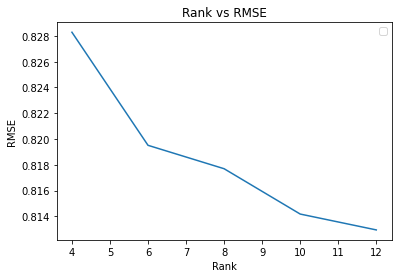

In [ ]:

plt.plot(ranks, error_list)

plt.legend()
plt.title('Rank vs RMSE')
plt.xlabel('Rank')
plt.ylabel('RMSE')

plt.show()

In [ ]:
# Build the recommendation model using ALS on the training data
error_list_reg = []

for reg in reg_list:
    als = ALS(maxIter=iterations, regParam=reg, userCol="userId", itemCol="movieId", 
              ratingCol="rating", coldStartStrategy="drop")
    model = als.fit(training)
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    error_list_reg.append(rmse)
    print(reg)
    print("Root-mean-square error = " + str(rmse))

0.1
Root-mean-square error = 0.8141818761421623
0.001
Root-mean-square error = 0.8545044678195689
0.0001
Root-mean-square error = 0.967146459486762


No handles with labels found to put in legend.


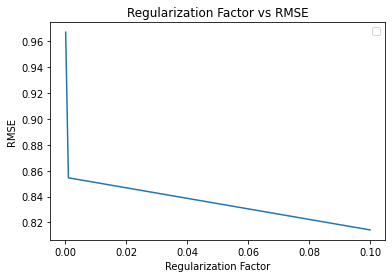

In [ ]:

plt.plot(reg_list, error_list_reg)

plt.legend()
plt.title('Regularization Factor vs RMSE')
plt.xlabel('Regularization Factor')
plt.ylabel('RMSE')

plt.show()

## Building the model with the best configurations 

In [ ]:
als = ALS(maxIter=iterations, rank=12, regParam=regularization_parameter, userCol="userId", itemCol="movieId", 
              ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
error_list.append(rmse)

print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8129514335331728


In [ ]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
userRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   148|[[154588, 5.29483...|
|   463|[[151989, 4.35569...|
|   471|[[144202, 5.55975...|
|   496|[[151989, 5.72557...|
|   833|[[120134, 5.88137...|
|  1088|[[144202, 6.56342...|
|  1238|[[151989, 4.93685...|
|  1342|[[88642, 5.06871]...|
|  1580|[[140323, 5.77201...|
|  1591|[[117907, 5.64485...|
|  1645|[[98693, 4.890036...|
|  1829|[[165689, 5.70665...|
|  1959|[[166812, 4.32237...|
|  2122|[[151989, 6.09608...|
|  2142|[[131359, 6.46597...|
|  2366|[[151989, 5.38253...|
|  2659|[[151989, 5.68631...|
|  2866|[[165689, 5.41376...|
|  3175|[[151989, 5.54334...|
|  3749|[[101862, 5.85834...|
+------+--------------------+
only showing top 20 rows



In [ ]:
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)
movieRecs.show()

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|    148|[[6829, 4.608085]...|
|    463|[[43804, 5.208755...|
|    471|[[97726, 5.47124]...|
|    496|[[113751, 5.27973...|
|    833|[[223997, 5.44316...|
|   1088|[[255815, 5.71337...|
|   1238|[[154320, 5.89566...|
|   1342|[[186374, 5.35254...|
|   1580|[[61540, 5.540261...|
|   1591|[[51433, 4.761017...|
|   1645|[[61540, 5.66028]...|
|   1829|[[44845, 4.938488...|
|   1959|[[44845, 5.614224...|
|   2122|[[186374, 5.25144...|
|   2142|[[110072, 5.18008...|
|   2366|[[154320, 6.03435...|
|   2659|[[87232, 4.977821...|
|   2866|[[154320, 5.39582...|
|   3175|[[154320, 5.59230...|
|   3749|[[134950, 5.68766...|
+-------+--------------------+
only showing top 20 rows



## Checking for number of iterations to avoid overfitting on training data 

In [ ]:
error_list_train = []
error_list_test = []

for epoch in range(iterations):
    als = ALS(maxIter=epoch, rank=12, regParam=regularization_parameter, userCol="userId", itemCol="movieId", 
              ratingCol="rating", coldStartStrategy="drop")
    model = als.fit(training)
    predictions1 = model.transform(training)
    predictions2 = model.transform(test)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
    rmse1 = evaluator.evaluate(predictions1)
    rmse2 = evaluator.evaluate(predictions2)
    error_list_train.append(rmse1)
    error_list_test.append(rmse2)
    print(epoch)
    print("Root-mean-square error = " + str(rmse2))

0
Root-mean-square error = 3.6971979034726807
1
Root-mean-square error = 3.4871857978249166
2
Root-mean-square error = 0.8798485728969366
3
Root-mean-square error = 0.8375128126467306
4
Root-mean-square error = 0.8258806239427203
5
Root-mean-square error = 0.8204495168049386
6
Root-mean-square error = 0.8175439256625885
7
Root-mean-square error = 0.815744810274317
8
Root-mean-square error = 0.8145074768861879
9
Root-mean-square error = 0.8136125754448493


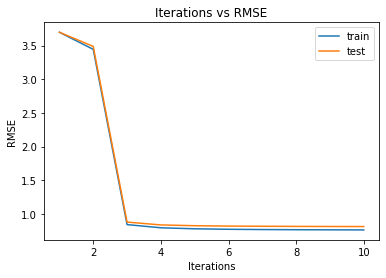

In [ ]:
epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.plot(epoch,error_list_train,label='train')
plt.plot(epoch, error_list_test,label='test')

plt.legend()
plt.title('Iterations vs RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')

plt.show()

In [ ]:
userRecs_pd = userRecs.toPandas()
userRecs_pd.to_csv(r"Users.csv", index = False)

In [ ]:
movieRecs_pd = movieRecs.toPandas()
movieRecs_pd.to_csv(r"Movies.csv", index = False)